<a href="https://colab.research.google.com/github/masalha-alaa/name-classification-pytorch/blob/master/name_classification_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import os
from google.colab import drive
!pip install unidecode
import unidecode

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.utils.data as data_utils

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

from pathlib import Path
import zipfile
from pickle import load

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn import utils

from bisect import bisect_left

import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import itertools
import copy
from math import ceil
from datetime import datetime

SEED = 42

In [62]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [63]:
# Use GPU if available

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {device}')

Running on cuda


In [64]:
# Extract data

DATA_DIR = Path("/content/gdrive/MyDrive/name-classification/")

if not os.path.exists(DATA_DIR / 'data'):
    print('Extracting data...')
    with zipfile.ZipFile(DATA_DIR / 'data.zip', 'r') as z:
        z.extractall(DATA_DIR)
    print('Done')

data = {}
for f in os.listdir(DATA_DIR / 'data'):
    data[f.replace('.txt', '')] = [unidecode.unidecode(name.strip().lower()) for name in open(DATA_DIR / 'data' / f).readlines()]

print(f"{len(data)} files: {data.keys()}")

18 files: dict_keys(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese'])


In [65]:
# Take a look at some data

show_langs, show_names = 4, 5
for i,(k,v) in enumerate(data.items()):
    print(f'{k}: {[name for name in v[:show_names]]}')
    if i == show_langs:
        break

Arabic: ['khoury', 'nahas', 'daher', 'gerges', 'nazari']
Chinese: ['ang', 'au-yong', 'bai', 'ban', 'bao']
Czech: ['abl', 'adsit', 'ajdrna', 'alt', 'antonowitsch']
Dutch: ['aalsburg', 'aalst', 'aarle', 'achteren', 'achthoven']
English: ['abbas', 'abbey', 'abbott', 'abdi', 'abel']


In [66]:
# Convert to dataframe for ease of use
DATA, LABEL = 'data', 'label'
df = pd.DataFrame(data=[[name, lang] for lang in data.keys() for name in data[lang]], columns=[DATA, LABEL]);
df_grouped = df.groupby(LABEL)
print(df_grouped.count())  # => it's massively biased!!!
df.sample(10)

            data
label           
Arabic      2000
Chinese      268
Czech        519
Dutch        297
English     3668
French       277
German       724
Greek        203
Irish        232
Italian      709
Japanese     991
Korean        94
Polish       139
Portuguese    74
Russian     9408
Scottish     100
Spanish      298
Vietnamese    73


,data,label
2681,skala,Czech
12339,dardyk,Russian
1460,awad,Arabic
8358,battaglia,Italian
2838,hout,Dutch
1781,safar,Arabic
1045,naifeh,Arabic
14769,juhnin,Russian
12415,demirchyan,Russian
1691,gerges,Arabic


In [67]:

df_train = df_grouped.sample(frac=0.8, random_state=SEED)
df_train_idx_set = set(df_train.index)
df_test = df.loc[[idx for idx in df.index if idx not in df_train_idx_set], :]
print(f"[Train]:\n{df_train.groupby(LABEL).count()}\n({df_train.shape[0]} entries)\n\nSamples:\n{df_train.sample(5, random_state=SEED)}")
print('')
print(f"[Test]:\n{df_test.groupby(LABEL).count()}\n({df_test.shape[0]} entries)\n\nSamples:\n{df_test.sample(5, random_state=SEED)}")

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

[Train]:
            data
label           
Arabic      1600
Chinese      214
Czech        415
Dutch        238
English     2934
French       222
German       579
Greek        162
Irish        186
Italian      567
Japanese     793
Korean        75
Polish       111
Portuguese    59
Russian     7526
Scottish      80
Spanish      238
Vietnamese    58
(16057 entries)

Samples:
          data    label
1775   shamoun   Arabic
2006      bian  Chinese
19994   zabala  Spanish
6373    towers  English
234      antar   Arabic

[Test]:
            data
label           
Arabic       400
Chinese       54
Czech        104
Dutch         59
English      734
French        55
German       145
Greek         41
Irish         46
Italian      142
Japanese     198
Korean        19
Polish        28
Portuguese    15
Russian     1882
Scottish      20
Spanish       60
Vietnamese    15
(4017 entries)

Samples:
            data    label
5295     mcelroy  English
5950      rivers  English
13532       grot  Russian
642

In [68]:
# encode labels

le = LabelEncoder()
encoded_lbls = le.fit_transform(list(data))  # list(data) makes a list of the dictionary's KEYS! (i.e. the countries)

def lbl_to_id(lbl):
    if torch.is_tensor(lbl):
        lbl = lbl.cpu().numpy()
    if isinstance(lbl, np.ndarray):
        return le.transform(lbl)[0]
    return le.transform([lbl])[0]

def id_to_lbl(lbl_id):
    if torch.is_tensor(lbl_id):
        lbl_id = lbl_id.cpu().numpy()
    if isinstance(lbl_id, np.ndarray):
        return le.inverse_transform(lbl_id)[0]
    return le.inverse_transform([lbl_id])[0]

In [69]:
# The unique characters in the files
vocab = sorted(set(' '.join(sum(data.values(), []))))
vocab_d = {k:v for v,k in enumerate(vocab)}
vocab_inv = {v:k for v,k in enumerate(vocab)}
print(f'{len(vocab)} unique characters')
print(vocab[:20])

33 unique characters
[' ', "'", ',', '-', '/', '1', ':', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm']


## Text Vectorization

In [70]:
# letters one hot encoding
def ltr_one_hot(ltr, num_cats):
    # num_cats: number of categories for the one hot encoding (usually len(vocab))
    def char_to_id(ch):
        return vocab_d[ch]
    return torch.nn.functional.one_hot(torch.LongTensor([char_to_id(ltr)]), num_cats)

# line one hot
def line_to_one_hot_tensor(line, num_cats):
    # num_cats: number of categories for the one hot encoding (usually len(vocab))
    line_one_hot = None
    for i, ltr in enumerate(line):
        if line_one_hot is None:
            line_one_hot = ltr_one_hot(ltr, num_cats)
            # print(line_one_hot.shape)
        else:
            line_one_hot = torch.cat([line_one_hot, ltr_one_hot(ltr, num_cats)])
    # return torch.unsqueeze(line_one_hot, 1)
    return line_one_hot.type(torch.FloatTensor)

def one_hot_tensor_to_line(one_hot_tensor):
    line = ''
    for one_hot_ltr in one_hot_tensor:
        line += vocab_inv[torch.argmax(one_hot_ltr).item()]
    return line

In [71]:
class MyDataset(Dataset):
    def __init__(self, dataframe):
        self.sequences = dataframe[DATA].apply(lambda name: line_to_one_hot_tensor(name, len(vocab))).tolist()
        self.labels = dataframe[LABEL].apply(lbl_to_id).tolist()
    
    def __getitem__(self, i):
        return self.sequences[i], self.labels[i]
    
    def __len__(self):
        return len(self.sequences)


training_dataset = MyDataset(df_train)
test_dataset = MyDataset(df_test)

train_loader = DataLoader(training_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [72]:
line_to_one_hot_tensor("slim shady", len(vocab)).shape

torch.Size([10, 33])

# Model

In [73]:
class RNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = 128
        self.num_layers = 1
        self.rnn = nn.RNN(input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def init_hidden(self):
        return torch.randn(self.num_layers, 1, self.hidden_size).to(device), None  # to make it match with LSTM

    def forward(self, x, h0):
        out, h0 = self.rnn(x, h0)
        # out = out.reshape(out.shape[0], -1)
        out = out[:, -1, :]
        out = self.softmax(self.fc(out))
        return out, h0, None  # the 3rd arg is to make it match with LSTM api


class ManualRNN(nn.Module):
    # from: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
    # (with modifications)
    def __init__(self, input_size, num_classes):
        super(ManualRNN, self).__init__()
        
        self.hidden_size = 128
        self.i2h = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.i2o = nn.Linear(input_size + self.hidden_size, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size).to(device), None  # to make it match with LSTM

    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 2)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = output[:, -1, :]
        output = self.softmax(output)
        return output, hidden, None  # the 3rd arg is to make it match with LSTM api


class LSTM(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = 128
        self.num_layers = 1
        self.rnn = nn.LSTM(input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def init_hidden(self):
        h0 = torch.randn(self.num_layers, 1, self.hidden_size).to(device)
        c0 = torch.randn(self.num_layers, 1, self.hidden_size).to(device)
        return h0, c0

    def forward(self, x, h0, c0):
        out, hidden = self.rnn(x, (h0, c0))
        h0, c0 = hidden
        # out = out.reshape(out.shape[0], -1)
        out = out[:, -1, :]
        out = self.softmax(self.fc(out))
        return out, h0, c0


class GRU(nn.Module):
    def __init__(self, input_size, num_classes):
        super(GRU, self).__init__()
        self.hidden_size = 128
        self.num_layers = 1
        self.rnn = nn.GRU(input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def init_hidden(self):
        return torch.randn(self.num_layers, 1, self.hidden_size).to(device), None  # to make it match with LSTM

    def forward(self, x, h0):
        out, hidden = self.rnn(x, h0)
        # out = out.reshape(out.shape[0], -1)
        out = out[:, -1, :]
        out = self.softmax(self.fc(out))
        return out, hidden, None  # the 3rd arg is to make it match with LSTM api


# model = RNN(len(vocab), len(data)).to(device)
# model = LSTM(len(vocab), len(data)).to(device)
# model = GRU(len(vocab), len(data)).to(device)
# model = ManualRNN(len(vocab), len(data)).to(device)
# => moved to the bottom

# Loss and optimizer
# criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
learning_rate = 0.005
# learning_rate = 0.0001
optimizer = lambda mdl: torch.optim.SGD(mdl.parameters(), lr=learning_rate)  
# optimizer = lambda mdl: torch.optim.Adam(mdl.parameters(), lr=learning_rate)

In [74]:
def softmax_to_prediction(softmax_output, classes):
    return classes[torch.argmax(softmax_output).item()]

In [75]:
# one step test
model_test = ManualRNN(len(vocab), len(data)).to(device)
input_tensor = ltr_one_hot('a', len(vocab)).to(device).unsqueeze(0)  # unsqueeze to imitate batch of size 1
input_tensor = input_tensor.type(torch.FloatTensor).to(device)
h0, c0 = model_test.init_hidden()

if c0 is None:
    output, next_hidden, _ = model_test(input_tensor, h0)
else:
    # LSTM
    output, next_hidden, cell_state = model_test(input_tensor.type(torch.FloatTensor), h0, c0)

print(f'input_tensor {input_tensor.shape}:\n{input_tensor}')
print(f'output {output.size()}')
print(f'next_hidden {next_hidden.size()}')

print(f'\nPrediction: {id_to_lbl(softmax_to_prediction(output, encoded_lbls))}')
model_test = None

input_tensor torch.Size([1, 1, 33]):
tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],
       device='cuda:0')
output torch.Size([1, 18])
next_hidden torch.Size([1, 1, 128])

Prediction: Irish


In [76]:
def evaluate(model, optim, line_tensor, category_tensor, train=False, log=False):
    h0, c0 = model.init_hidden()
    
    for ltr_one_hot in line_tensor[0]:
        if c0 is None:
            output, h0, _ = model(torch.reshape(ltr_one_hot, (1,1,-1)), h0)
        else:
            # LSTM
            output, h0, c0 = model(torch.reshape(ltr_one_hot, (1,1,-1)), h0, c0)
    
    if log:
        print(f'output {output.shape}:\n{output}')
        print(f'category_tensor {category_tensor.shape}:\n{category_tensor}')
    loss = criterion(output, category_tensor)
    
    if train:
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    return output, loss.item()

In [77]:
def train(model):
    ts = datetime.now()
    print(ts)
    print('')

    optim = optimizer(model)
    train_losses, validation_losses = [], []
    epochs = 30
    model.train(mode=True)
    for epoch in range(epochs):
        epoch_train_loss, epoch_validation_loss = 0, 0
        for name_tensor, label in train_loader:
            name_tensor, label = name_tensor.to(device), label.to(device)

            output, loss = evaluate(model, optim, name_tensor, label, train=True)
            epoch_train_loss += loss
        
        train_losses.append(epoch_train_loss / len(training_dataset))

        # validation eval
        model.train(mode=False)  # enter eval mode
        for val_data, val_labels in test_loader:
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            val_output, val_loss = evaluate(model, None, val_data, val_labels)
            epoch_validation_loss += val_loss
            
        validation_losses.append(epoch_validation_loss / len(test_dataset))
        model.train(mode=True)  # exit eval mode, re-enter training mode
            
        print(f"Epoch {epoch}: Training Loss: {train_losses[-1]:.4f}, Validation Loss: {validation_losses[-1]:.4f}")
            

    print('')
    print(f'Training Time: {datetime.now() - ts}')
    plt.figure()
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.show()

In [78]:
def test(model):
    model.train(mode=False)  # enter eval mode
    # with torch.no_grad():  # locally disable gradient tracking? (no, should not do it in RNN, becaues we do want grads to accumulate!)
    print_cnt, print_num = 0, 20
    for val_data, val_labels in test_loader:
        val_data, val_labels = val_data.to(device), val_labels.to(device)
        
        val_output, _ = evaluate(model, None, val_data, val_labels)
        pred = id_to_lbl(softmax_to_prediction(val_output, encoded_lbls))

        name = one_hot_tensor_to_line(val_data.squeeze(0))
        lbl = id_to_lbl(val_labels)
        
        print(f"Name: {name:<16} Label: {lbl:<20} Prediction: {pred:<16} -- {'CORRECT' if lbl == pred else 'INCORRECT'}")
        print_cnt += 1
        if print_cnt == print_num:
            break

ManualRNN(
  (i2h): Linear(in_features=161, out_features=128, bias=True)
  (i2o): Linear(in_features=161, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)
2021-08-01 17:57:25.355467

Epoch 0: Training Loss: 1.4152, Validation Loss: 1.1575
Epoch 1: Training Loss: 1.1128, Validation Loss: 1.0454
Epoch 2: Training Loss: 1.0194, Validation Loss: 1.0271
Epoch 3: Training Loss: 0.9711, Validation Loss: 0.9774
Epoch 4: Training Loss: 0.9396, Validation Loss: 0.9429
Epoch 5: Training Loss: 0.9226, Validation Loss: 0.9296
Epoch 6: Training Loss: 0.8996, Validation Loss: 0.8967
Epoch 7: Training Loss: 0.8874, Validation Loss: 0.8778
Epoch 8: Training Loss: 0.8774, Validation Loss: 0.8813
Epoch 9: Training Loss: 0.8698, Validation Loss: 0.8529
Epoch 10: Training Loss: 0.8603, Validation Loss: 0.8543
Epoch 11: Training Loss: 0.8591, Validation Loss: 0.8725
Epoch 12: Training Loss: 0.8490, Validation Loss: 0.8514
Epoch 13: Training Loss: 0.8456, Validation Loss: 0.8625
Epoch 14: Trainin

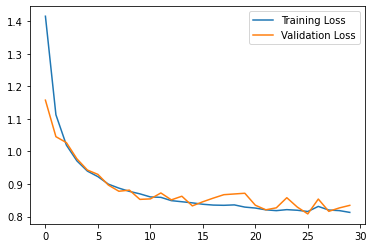

Name: antoun           Label: Arabic               Prediction: Arabic           -- CORRECT
Name: eoin             Label: Irish                Prediction: Russian          -- INCORRECT
Name: karnoupakis      Label: Greek                Prediction: Greek            -- CORRECT
Name: sayegh           Label: Arabic               Prediction: Arabic           -- CORRECT
Name: ganem            Label: Arabic               Prediction: Arabic           -- CORRECT
Name: turyanov         Label: Russian              Prediction: Russian          -- CORRECT
Name: gaskoin          Label: Russian              Prediction: Russian          -- CORRECT
Name: seredov          Label: Russian              Prediction: Russian          -- CORRECT
Name: plant            Label: English              Prediction: English          -- CORRECT
Name: engelmeier       Label: Russian              Prediction: German           -- INCORRECT
Name: katzibin         Label: Russian              Prediction: Russian          -- COR

In [81]:
model = ManualRNN(len(vocab), len(data)).to(device)
print(model)
train(model)
test(model)

RNN(
  (rnn): RNN(33, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)
2021-08-01 18:17:03.598536

Epoch 0: Training Loss: 1.4166, Validation Loss: 1.2148
Epoch 1: Training Loss: 1.1372, Validation Loss: 1.1273
Epoch 2: Training Loss: 1.0573, Validation Loss: 1.0346
Epoch 3: Training Loss: 1.0126, Validation Loss: 0.9701
Epoch 4: Training Loss: 0.9718, Validation Loss: 1.0111
Epoch 5: Training Loss: 0.9343, Validation Loss: 0.9359
Epoch 6: Training Loss: 0.8989, Validation Loss: 0.8995
Epoch 7: Training Loss: 0.8654, Validation Loss: 0.8528
Epoch 8: Training Loss: 0.8405, Validation Loss: 0.8408
Epoch 9: Training Loss: 0.8094, Validation Loss: 0.8291
Epoch 10: Training Loss: 0.7905, Validation Loss: 0.8228
Epoch 11: Training Loss: 0.7721, Validation Loss: 0.8476
Epoch 12: Training Loss: 0.7528, Validation Loss: 0.7873
Epoch 13: Training Loss: 0.7322, Validation Loss: 0.7848
Epoch 14: Training Loss: 0.7271, Validation Lo

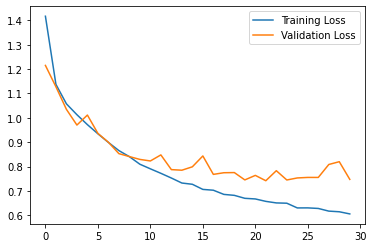

Name: ayling           Label: English              Prediction: English          -- CORRECT
Name: duarte           Label: Spanish              Prediction: English          -- INCORRECT
Name: hadad            Label: Arabic               Prediction: Arabic           -- CORRECT
Name: von grimmelshausen Label: German               Prediction: Dutch            -- INCORRECT
Name: kurata           Label: Japanese             Prediction: Japanese         -- CORRECT
Name: schultz          Label: German               Prediction: German           -- CORRECT
Name: livadin          Label: Russian              Prediction: Russian          -- CORRECT
Name: nadwornik        Label: Czech                Prediction: Russian          -- INCORRECT
Name: belogolovy       Label: Russian              Prediction: Czech            -- INCORRECT
Name: esmansky         Label: Russian              Prediction: Russian          -- CORRECT
Name: naser            Label: Arabic               Prediction: Arabic           

In [82]:
model = RNN(len(vocab), len(data)).to(device)
print(model)
train(model)
test(model)

GRU(
  (rnn): GRU(33, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)
2021-08-01 16:24:26.075286

Epoch 0: Training Loss: 1.6094, Validation Loss: 1.4051
Epoch 1: Training Loss: 1.3087, Validation Loss: 1.2254
Epoch 2: Training Loss: 1.1731, Validation Loss: 1.1307
Epoch 3: Training Loss: 1.0918, Validation Loss: 1.0937
Epoch 4: Training Loss: 1.0361, Validation Loss: 1.0851
Epoch 5: Training Loss: 0.9908, Validation Loss: 0.9811
Epoch 6: Training Loss: 0.9564, Validation Loss: 0.9512
Epoch 7: Training Loss: 0.9296, Validation Loss: 0.9259
Epoch 8: Training Loss: 0.8968, Validation Loss: 0.8999
Epoch 9: Training Loss: 0.8689, Validation Loss: 0.8626
Epoch 10: Training Loss: 0.8420, Validation Loss: 0.8620
Epoch 11: Training Loss: 0.8148, Validation Loss: 0.8304
Epoch 12: Training Loss: 0.7909, Validation Loss: 0.7986
Epoch 13: Training Loss: 0.7647, Validation Loss: 0.7778
Epoch 14: Training Loss: 0.7420, Validation Lo

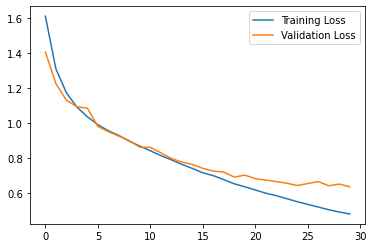

Name: francis          Label: English              Prediction: English          -- CORRECT
Name: vabbe            Label: Russian              Prediction: English          -- INCORRECT
Name: york             Label: English              Prediction: English          -- CORRECT
Name: anikanov         Label: Russian              Prediction: Russian          -- CORRECT
Name: smart            Label: English              Prediction: English          -- CORRECT
Name: ekin             Label: Russian              Prediction: Russian          -- CORRECT
Name: sasada           Label: Japanese             Prediction: Japanese         -- CORRECT
Name: markholenko      Label: Russian              Prediction: Russian          -- CORRECT
Name: diaz             Label: Spanish              Prediction: Arabic           -- INCORRECT
Name: awad             Label: Arabic               Prediction: Arabic           -- CORRECT
Name: sayegh           Label: Arabic               Prediction: Arabic           -- COR

In [79]:
model = GRU(len(vocab), len(data)).to(device)
print(model)
train(model)
test(model)

LSTM(
  (rnn): LSTM(33, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)
2021-08-01 17:01:40.059244

Epoch 0: Training Loss: 1.7380, Validation Loss: 1.5510
Epoch 1: Training Loss: 1.4568, Validation Loss: 1.3744
Epoch 2: Training Loss: 1.3053, Validation Loss: 1.2320
Epoch 3: Training Loss: 1.1787, Validation Loss: 1.1391
Epoch 4: Training Loss: 1.1009, Validation Loss: 1.0731
Epoch 5: Training Loss: 1.0448, Validation Loss: 1.0136
Epoch 6: Training Loss: 1.0003, Validation Loss: 1.0076
Epoch 7: Training Loss: 0.9645, Validation Loss: 0.9466
Epoch 8: Training Loss: 0.9327, Validation Loss: 0.9142
Epoch 9: Training Loss: 0.9032, Validation Loss: 0.9105
Epoch 10: Training Loss: 0.8760, Validation Loss: 0.9007
Epoch 11: Training Loss: 0.8516, Validation Loss: 0.8534
Epoch 12: Training Loss: 0.8263, Validation Loss: 0.8515
Epoch 13: Training Loss: 0.8081, Validation Loss: 0.8319
Epoch 14: Training Loss: 0.7873, Validation 

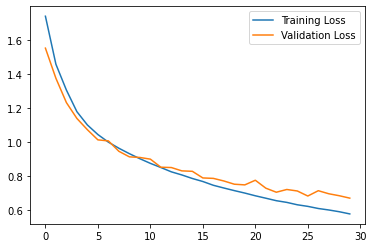

Name: elepov           Label: Russian              Prediction: Russian          -- CORRECT
Name: itami            Label: Japanese             Prediction: Arabic           -- INCORRECT
Name: bakinoff         Label: Russian              Prediction: Russian          -- CORRECT
Name: pakhomov         Label: Russian              Prediction: Russian          -- CORRECT
Name: mifsud           Label: Arabic               Prediction: Arabic           -- CORRECT
Name: hurley           Label: English              Prediction: English          -- CORRECT
Name: avkhimovitch     Label: Russian              Prediction: Russian          -- CORRECT
Name: dirchs           Label: German               Prediction: English          -- INCORRECT
Name: moghadam         Label: Arabic               Prediction: Arabic           -- CORRECT
Name: tcheharin        Label: Russian              Prediction: Russian          -- CORRECT
Name: jivlyuk          Label: Russian              Prediction: Russian          -- COR

In [80]:
model = LSTM(len(vocab), len(data)).to(device)
print(model)
train(model)
test(model)